In [649]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
from time import time

In [653]:
###################GENERATED SIMULATED DATA################################
nsensors = 2

#In X, start sensor ids from zero.
ndims = 1 #number of dimensions besides the sensor id column
X = np.zeros([0,ndims+1]) #time,sensor
y = np.zeros([0,1])
nsamps = [50,100]
realy = np.zeros([0,1])
realX = np.zeros([0,1])
for sensori in range(nsensors):
    newX = np.c_[np.linspace(sensori*4,sensori*4+5,nsamps[sensori]),np.full(nsamps[sensori],sensori)]
    newy = 6*(1.5+np.cos(newX[:,0:1]/3))
    realX = np.r_[realX,newX[:,0:1]]
    realy = np.r_[realy,newy]
    if sensori==1:
        newy = newy*2.0 + np.random.randn(nsamps[sensori])[:,None]
    X = np.r_[X,newX]
    y = np.r_[y,newy]
    

#y = y - np.mean(y)
#y = y / np.std(y)
#X = tf.Variable(X,dtype=np.float32)
#y = tf.Variable(y,dtype=np.float32)
    
##################Build inducing points, variational distributions, etc.#############
#we need a point in X, at, say sensorid=-1 for every sensor's measurement.
#this is so we can multiply the sensor value with the latent function

class Sensor():
    def K(self,X1,X2):
        assert False, "Not Implemented"
    
        #assert False, "Not implemented"
    def __init__(self,num_inducing = 4):
        self.reference = False
        self.num_inducing = num_inducing
        #self.X = tf.Variable(X,dtype=tf.float32)
        #self.y = tf.Variable(y,dtype=tf.float32)
        self.Z = tf.Variable(np.linspace(-1,11,num_inducing)[:,None],dtype=tf.float32)
        
        #q(u): [things we optimise!]
        self.qmu = tf.Variable(tf.random.normal([num_inducing]),dtype=tf.float32)#, name='mu')        
        self.qscale = tf.Variable(tf.random.normal([num_inducing,num_inducing]),dtype=tf.float32)
        
        #p(u):
        self.pmu = tf.zeros([1,num_inducing],dtype=tf.float32)
        self.pcov = tf.Variable(self.K(self.Z,self.Z),dtype=tf.float32)
        self.pu = tfd.MultivariateNormalFullCovariance(self.pmu,self.pcov+np.eye(self.pcov.shape[0])*0.01)

    def get_qu(self):
        """Return the multivariate normal defined by our qmu and qscale"""
        return tfd.MultivariateNormalTriL(self.qmu,self.qscale)
    
    def compute_qf_parameters(self,X):
        """Compute mean and covariance of q(f)"""
        #q(u)
        qu = self.get_qu()
        
        #q(f)
        #TODO switch to numerically stable code & move inverse out of loop (e.g. precompute in constructor)
        invKzz = tf.linalg.inv(self.K(self.Z,self.Z)+np.eye(self.num_inducing,dtype=np.float32)*0.1)
        #print(invKzz)
        qf_mu = self.K(X,self.Z) @ invKzz @ self.qmu[:,None]
        #print(qf_mu)
        qf_cov = self.K(X,X) - self.K(X,self.Z) @ invKzz @ self.K(self.Z,X) + \
            self.K(X,self.Z)@ invKzz @(self.qscale@tf.transpose(self.qscale))@ invKzz @ self.K(self.Z,X)
        #print(qf_cov)
        
        
        #Kzz = self.K(self.Z,self.Z)#+np.eye(self.num_inducing,dtype=np.float32)*1.0
        #stable_qf_mu = np.linalg.solve(Kzz,self.K(self.Z,X)).T @ self.qmu[:,None]
        #stable_qf_cov = self.K(X,X) - np.linalg.solve(Kzz,self.K(self.Z,X)).T @ self.K(self.Z,X) + \
        #    np.linalg.solve(Kzz,self.K(self.Z,X)).T @ np.linalg.solve(Kzz,self.qscale@tf.transpose(self.qscale)) @ self.K(self.Z,X)
        
        
        return qf_mu, qf_cov
    
    def getlogpriorelbo(self):
        """Need better method name"""
        return tfd.kl_divergence(self.get_qu(),self.pu)
    
class LowCostSensor(Sensor):
    def K(self,X1,X2):
        return 0.1*tf.exp(-np.sum(np.subtract(X1[:,None],X2[None,:])**2/(2*10**2),2))    
    def __init__(self,num_inducing = 4):
        super().__init__(num_inducing)
        self.likelihoodnoise = 0.1
        #self.qmu = tf.Variable(tf.zeros([num_inducing]),dtype=tf.float32)#, name='mu')
        #self.qscale =tf.Variable(np.eye(num_inducing),dtype=tf.float32)
        self.qmu = tf.Variable(tf.random.normal([num_inducing]),dtype=tf.float32)#, name='mu')        
        self.qscale = tf.Variable(0.01*tf.random.normal([num_inducing,num_inducing]),dtype=tf.float32)
    #def K(self,X1,X2):
        

class ReferenceSensor(Sensor):
    def K(self,X1,X2):
        return 0.001*tf.exp(-np.sum(np.subtract(X1[:,None],X2[None,:])**2/(2*10**2),2))    
    
    def __init__(self,num_inducing = 4):
        super().__init__(num_inducing)
        self.reference = True
        self.likelihoodnoise = 0.1
        self.qmu = tf.Variable(tf.zeros([num_inducing]),dtype=tf.float32)#, name='mu')
        self.qscale = tf.Variable(np.eye(num_inducing),dtype=tf.float32)
    #def K(self,X1,X2):
    #    return 100*tf.exp(-np.sum(np.subtract(X1[:,None],X2[:,:-1][None,:])**2/(2*1**2),2))

class Latent(Sensor):
    def K(self,X1,X2):
        return 400*tf.exp(-np.sum(np.subtract(X1[:,None],X2[None,:])**2/(2*4**2),2))    
    
sensors = []
#sensors.append(ReferenceSensor(10))
#sensors.append(LowCostSensor(10))
#sensors.append(LowCostSensor(10))


sensors.append(ReferenceSensor(10))
sensors.append(LowCostSensor(10))
latent = Latent(10)

In [654]:
st = time()
for it in range(60):
    warning = False
    with tf.GradientTape() as tape:
        #
        #latent_qf_mu, latent_qf_cov = latent.compute_qf_parameters()
        elbo_loss = 0
        for sensori, sensor in enumerate(sensors):
            
            selforsensor = np.where(X[:,-1]==sensori)[0]
            ratio = len(selforsensor)/50
            selforsensor = selforsensor[np.random.choice(len(selforsensor),30,replace=False)]
            
            Xforsensor = tf.Variable(X[selforsensor,:-1],dtype=np.float32) #maybe need to convert to TF?
            yforsensor =tf.Variable(y[selforsensor,:],dtype=np.float32)
            
            if not sensor.reference:
                qf_mu, qf_cov = sensor.compute_qf_parameters(Xforsensor)
            latent_qf_mu, latent_qf_cov = latent.compute_qf_parameters(Xforsensor)
            
            for i in range(Xforsensor.shape[0]):
                var = latent_qf_cov[i,i]
                if var<=0: 
                    warning = True
                    var = 1e-6
                dist_latent = tfd.Normal(latent_qf_mu[i,0],tf.sqrt(var))
                if not sensor.reference:
                    var = qf_cov[i,i]
                    if var<=0: 
                        var = 1e-6
                        warning = True
                    dist_f = tfd.Normal(qf_mu[i,0],tf.sqrt(var))
                    f = dist_f.sample(1000)
                lat = dist_latent.sample(1000)
                #contribution of ELL
                if sensor.reference:
                    elbo_loss-=tf.math.reduce_mean(tfd.Normal(lat,sensor.likelihoodnoise).log_prob(yforsensor[i]))
                else:
                    elbo_loss-=tf.math.reduce_mean(tfd.Normal(tf.exp(f)*lat,sensor.likelihoodnoise).log_prob(yforsensor[i]))
                #contribution of prior
            #print(elbo_loss)
            elbo_loss *= ratio #correct for minibatch size.
            elbo_loss += sensor.getlogpriorelbo()
        #elbo_loss = -elbo_loss
        elbo_loss += latent.getlogpriorelbo()
    if warning: break
    gradlist = [latent.qmu, latent.qscale]
    for sensor in sensors:
        if not sensor.reference:
            gradlist.append(sensor.qmu)
            gradlist.append(sensor.qscale)
    gradients = tape.gradient(elbo_loss, gradlist)
    optimizer.apply_gradients(zip(gradients, gradlist))
    #sensors[0].qmu = tf.zeros([10],dtype=tf.float32)
    if it%5 == 0: 
        print("%d %0.2f %0.4f %0.0f" % (it,time()-st,(time()-st)/(it+1),elbo_loss.numpy()))#,qf_mu[:,0].numpy(),mu.numpy())
        if warning: print("!!Handling negative variances with hack")
    #print(sensors[0].qmu.numpy())

0 0.39 0.3909 1241778
5 2.40 0.4004 952093
10 4.27 0.3886 791082
15 6.07 0.3793 753563
20 8.02 0.3820 567182
25 10.23 0.3935 365211
30 12.31 0.3971 297644
35 14.37 0.3992 194650
40 16.24 0.3962 176405
45 18.28 0.3974 156142
50 20.91 0.4101 120487
55 22.71 0.4056 106702


/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: covariance is not positive-semidefinite.
  
/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: covariance is not positive-semidefinite.
  # This is added back by InteractiveShellApp.init_path()
/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: covariance is not positive-semidefinite.


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 1.239  3.113  2.263  0.789 -0.108  1.847  1.58   0.533  0.614  0.556]


/home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: covariance is not positive-semidefinite.


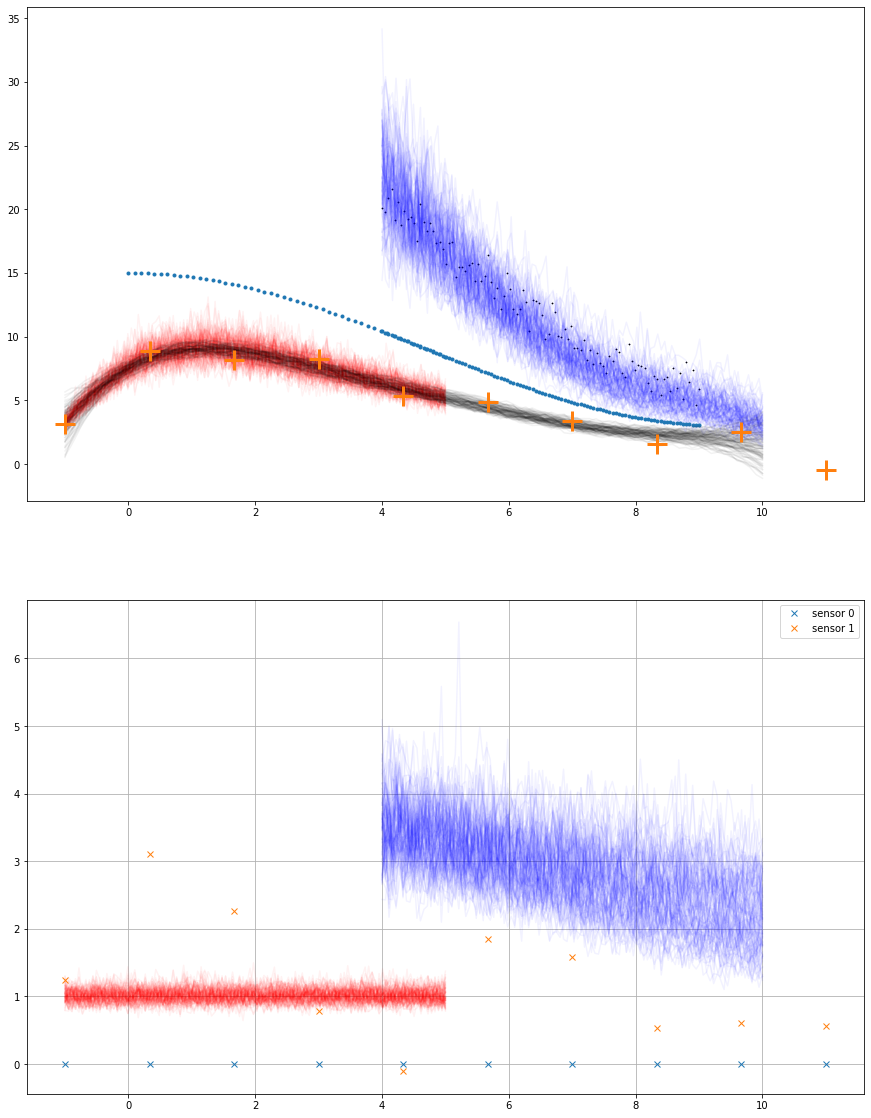

In [655]:
plt.figure(figsize=[15,20])
plt.subplot(2,1,1)
col = ['r','b']
for sensori,sensor in enumerate(sensors):
    Xforsensor = tf.Variable(np.linspace(sensori*5-1,sensori*5+4+1,110)[:,None],dtype=np.float32) #maybe need to convert to TF?
    qmu, qcov = sensor.compute_qf_parameters(Xforsensor)

    samps = np.random.multivariate_normal(qmu[:,0],qcov+np.eye(qcov.shape[0])*0.01,100)
    latqmu, latqcov = latent.compute_qf_parameters(Xforsensor)

    latsamps = np.random.multivariate_normal(latqmu[:,0],qcov+np.eye(latqcov.shape[0])*0.01,100)


    plt.plot(X[:,0],y[:,0],'.k',markersize=1)
    plt.plot(Xforsensor.numpy()[:,0],tf.exp(samps.T)*latsamps.T,'-',color=col[sensori],alpha=0.05)#,label="posterior %d" % sensori);    

plt.plot(realX[:,0],realy[:,0],'.')
    
Xforlat = tf.Variable(np.linspace(-1,10,110)[:,None],dtype=np.float32) #maybe need to convert to TF?
latqmu, latqcov = latent.compute_qf_parameters(Xforlat)
latsamps = np.random.multivariate_normal(latqmu[:,0],latqcov+np.eye(latqcov.shape[0])*0.01,100)
qmu, qcov = sensor.compute_qf_parameters(Xforlat)    
plt.plot(Xforlat.numpy()[:,0],latsamps.T,'-',color='k',alpha=0.05)#,label="posterior %d" % sensori);


Xstar = np.linspace(-5,15,1000)[:,None]

#invKzz = tf.linalg.inv(sensor.K(sensor.Z,sensor.Z)+np.eye(sensor.num_inducing,dtype=np.float32)*0.01)
#mean = (sensor.K(Xstar,sensor.Z) @ invKzz @ sensor.qmu.numpy()[:,None]).numpy()[:,0]
#cov = sensor.K(Xstar,Xstar) - sensor.K(Xstar,sensor.Z) @ invKzz @ sensor.K(sensor.Z,Xstar)
#stds = np.sqrt(np.diag(cov))

#plt.plot(Xstar,mean,'r-',lw=3);
#plt.plot(Xstar,mean+stds,'r-',lw=1);
#plt.plot(Xstar,mean-stds,'r-',lw=1);
plt.plot(latent.Z.numpy()[:,0],latent.qmu.numpy(),'+',mew=3,markersize=20,label="latent")

plt.subplot(2,1,2)
for sensori,sensor in enumerate(sensors):
    print(sensor.qmu.numpy())
    Xforsensor = tf.Variable(np.linspace(sensori*5-1,sensori*5+4+1,110)[:,None],dtype=np.float32) #maybe need to convert to TF?
    qmu, qcov = sensor.compute_qf_parameters(Xforsensor)

    samps = np.random.multivariate_normal(qmu[:,0],qcov+np.eye(qcov.shape[0])*0.01,100)
    plt.plot(Xforsensor.numpy()[:,0],tf.exp(samps.T),'-',color=col[sensori],alpha=0.05)#,label="posterior %d" % sensori);
    plt.plot(sensor.Z.numpy()[:,0],sensor.qmu.numpy(),'x',label="sensor %d" % sensori)
    #plt.plot(latent.Z.numpy()[:,0],tf.exp(sensor.qmu.numpy())*latent.qmu.numpy(),'x',markersize=10,mew=3, label="product %d" % sensori)
#plt.ylim([-15,30])
plt.legend()
plt.grid()

In [458]:
sensors[1].qmu

<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=
array([ 2.08 ,  1.896,  1.712,  1.331,  0.648,  0.11 , -0.463, -0.874,
       -1.433, -1.808], dtype=float32)>

In [227]:
sensors[1].qscale

<tf.Variable 'Variable:0' shape=(5, 5) dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)>